In [1]:
import numpy as np
import import_ipynb
import time

In [123]:
# = = = Global Configuration = = =

scale_factor = 100
prob_threshold = 1 / scale_factor
total_dims = 16 # the dimensions of lineitem table
domain_dims = 8 # the dimensions we used and maintain min max for
chunk_size = 100000

# base_table_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/9a84f6cd-727f-4f10-ae95-10a0214e10a4-tpc-h-tool/2.18.0_rc2/dbgen/lineitem_'
# table_path = base_table_path + str(scale_factor) + '.tbl'

base_save_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/dataset/lineitem_'
save_path_data = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '.csv'
save_path_domain = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '_domains.csv'

block_size = 1000000 // scale_factor # in original file, 1M rows take approximately 128MB

In [124]:
# = = = Data Loading = = =
dataset = np.genfromtxt(save_path_data, delimiter=',') # the sampled subset
domains = np.genfromtxt(save_path_domain, delimiter=',') # the domain of that scale

# Configuration
used_dimensions = [1,2] # the second and third dimensions

dataset = dataset[:,used_dimensions]
domains = domains[used_dimensions]

In [125]:
# = = = Query Loading = = =
from QueryGeneration import *

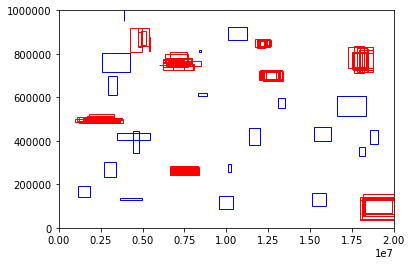

In [141]:
# = = = Query Generation = = =

# Configuration
total_queries = 100
random_percentage = 0.2
maximum_random_range = [int((domains[i,1] - domains[i,0])*0.1) for i in range(len(domains))]
cluster_amount = 8
maximum_range_dis = [int((domains[i,1] - domains[i,0])*0.1) for i in range(len(domains))]
sigmas_percentage = [0.2,0.2]
random_shift = False
return_seperate = True

mixed_queris = generate_query_with_random(total_queries, random_percentage, domains, maximum_random_range, 
                                          cluster_amount, maximum_range_dis, sigmas_percentage, random_shift, return_seperate)

plot_queries_2d_distribution_and_random(mixed_queris[1], mixed_queris[0], domains)

In [142]:
# = = = Query Saving / Loading = = =

# Configuration
query_base_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/'

distribution_path = query_base_path + 'distribution_' + str(scale_factor) + '.csv'
random_path = query_base_path + 'random_' + str(scale_factor) + '.csv'

# save the generated queries
save_query(mixed_queris[1], distribution_path)
save_query(mixed_queris[0], random_path)

# if the query is generated from another domain, it should be regenerated!
distribution_query = load_query(distribution_path)
random_query = load_query(random_path)

distribution_segmentation = int(total_queries * (1 - random_percentage) / 2)
random_segmentation = int(total_queries * random_percentage / 2)

training_set = np.concatenate((random_query[0:random_segmentation], distribution_query[0:distribution_segmentation]), axis=0)
testing_set = np.concatenate((random_query[random_segmentation:], distribution_query[distribution_segmentation:]), axis = 0)

In [143]:
from Query import *
from Utils import *

In [144]:
# = = = Qd-Tree = = =
from Qd_tree import *

# Configuration
qdtree_partition_base_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/HDFSExperiment/generated_partitions/'
qdtree_path = qdtree_partition_base_path + 'qdtree_partitions_' + str(scale_factor)

In [145]:
# = = = Qd-Tree = = =
start_time = time.time()

qdtree_kdnodes = Qd_tree_greedy_optimized_approximate(dataset, training_set, domains, block_size, bins=(4000,1000))

end_time = time.time()
print("training time for Qd-Tree (s): ", end_time-start_time)
print('Qd-Tree leaf nodes: ',len(qdtree_kdnodes))

# Qd-Tree Query
Query(testing_set, qdtree_kdnodes)
Query(training_set, qdtree_kdnodes)

# Save Partition
saved_qdtree_partitions = save_partitions_to_file(qdtree_kdnodes, qdtree_path)

current kdnodes:  1
current inner loop i:  0
current kdnodes:  2
current inner loop i:  0
current inner loop i:  1
current kdnodes:  4
current inner loop i:  0
current inner loop i:  1
current inner loop i:  2
current inner loop i:  3
current kdnodes:  8
current inner loop i:  0
current inner loop i:  1
current inner loop i:  2
current inner loop i:  3
current inner loop i:  4
current inner loop i:  5
current inner loop i:  6
current inner loop i:  7
current kdnodes:  16
current inner loop i:  0
current inner loop i:  1
current inner loop i:  2
current inner loop i:  3
current inner loop i:  4
current inner loop i:  5
current inner loop i:  6
current inner loop i:  7
current inner loop i:  8
current inner loop i:  9
current inner loop i:  10
current inner loop i:  11
current inner loop i:  12
current inner loop i:  13
current inner loop i:  14
current inner loop i:  15
current kdnodes:  32
current inner loop i:  0
current inner loop i:  1
current inner loop i:  2
current inner loop i: 

In [146]:
# = = = NORA = = =
from LKD_Robust import *

# Configuration
data_threshold = block_size
query_threshold = 2
hist_m, hist_n = 1000, 1000
nora_partition_base_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/HDFSExperiment/generated_partitions/'
nora_path = nora_partition_base_path + 'nora_partitions_' + str(scale_factor)

In [147]:
# = = = NORA = = =
start_time = time.time()

nora_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist = LKD_Robust_Initialization(
    dataset, training_set, domains, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

end_time = time.time()
print("training time for NORA (s): ", end_time-start_time)
print('NORA leaf nodes: ',len(nora_kdnodes))

# NORA Query
Query(testing_set, nora_kdnodes)
Query(training_set, nora_kdnodes)

# Save Partition
saved_nora_partitions = save_partitions_to_file(nora_kdnodes, nora_path)

training time for NORA (s):  7.714357137680054
NORA leaf nodes:  421
average partitions each query overlap(average):  3.94
average records each query retrieve(average):  52381.18
total records that all the queries retrieve:  2619059
average partitions each query overlap(average):  2.76
average records each query retrieve(average):  37576.68
total records that all the queries retrieve:  1878834


In [148]:
# = = = Visualization = = =
from Utils import *
qdtree_kdnodes = load_partitions_from_file(qdtree_path)
nora_kdnodes = load_partitions_from_file(nora_path)

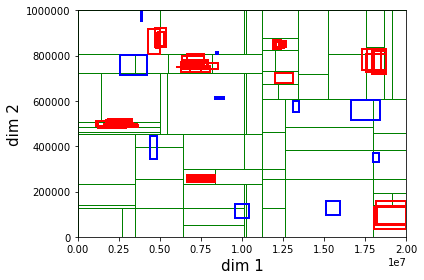

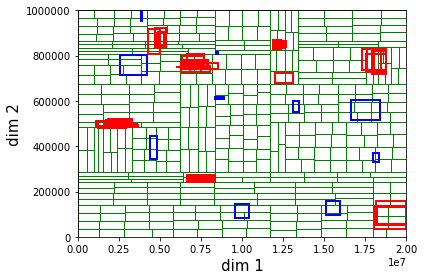

In [149]:
# testing set, Qd-Tree
visualize_kdnodes_and_query_2(qdtree_kdnodes, distribution_query[distribution_segmentation:], random_query[random_segmentation:], domains) 
# testing set, NORA\
visualize_kdnodes_and_query_2(nora_kdnodes, distribution_query[distribution_segmentation:], random_query[random_segmentation:], domains)

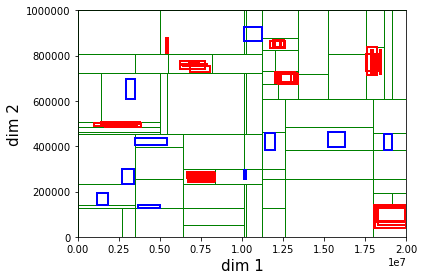

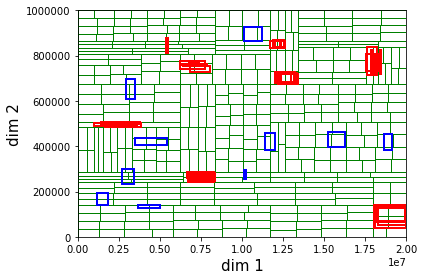

In [150]:
# training set, Qd-Tree
visualize_kdnodes_and_query_2(qdtree_kdnodes, distribution_query[0:distribution_segmentation], random_query[0:random_segmentation], domains) 
# training set, NORA
visualize_kdnodes_and_query_2(nora_kdnodes, distribution_query[0:distribution_segmentation], random_query[0:random_segmentation], domains)

In [135]:
# consider the border of some queries?